# Physical activity and sleep notebook:

### Contents:

1. Loading dependencies
2. Processing and extraction

## 1. Loading dependencies

In [1]:
#Package loading
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from datetime import datetime, date, time, timedelta

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib import rcParams
from matplotlib.dates import DateFormatter
from matplotlib import rc
from matplotlib.dates import date2num
from IPython import display
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib.dates as dates
%matplotlib inline

from scipy import stats as sps
from scipy.interpolate import interp1d

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor

import statsmodels.api as sm
from CosinorPy import file_parser, cosinor, cosinor1

import glob
import math
from os import path
from collections import defaultdict
import nolds
import pyActigraphy as pyAc
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14,8)
plt.rcParams['font.size'] = 18
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
plt.rc('font', family='serif')

## 2. Processing and extraction

In [35]:
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')
from preprocessing import Subject

filelist = ['dummy5_full.csv','dummy3_full.csv','dummy2_full.csv']#,'dummy1_full.csv']#,
           # 'dummybbvs_1.csv', 'dummybbvs_2.csv']

def get_data(filelist):
    d = defaultdict(dict)
    for idx, filename in enumerate(filelist):
        d[idx] = Subject(filename)
        d[idx].get_METS()
        d[idx].get_HRV()
        d[idx].get_PA()
        #d[idx].get_sleep_grid(q_sleep=[0.35,0.4,0.45], bed_time = '20:00',wake_time = '12:00', seq_length = 15)
        #d[idx].get_windows()
        #d[idx].get_SRI(q_sleep=0.4)
        #d[idx].get_ARI()
        #d[idx].get_cosinor()
        #d[idx].get_SSA()
        #d[idx].get_nonlinear()
        #d[idx].Crespo(zeta=15, zeta_r=50, zeta_a=2,t=.50, alpha='7h', beta='1h',
        #              estimate_zeta=False, seq_length_max=100, verbose=False)
        #Depends on running METS,PA,sleep, windows, SRI, SSA and nonlinear first
        #d[idx].get_daily_stats()
    return d

d = get_data(filelist)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')
from preprocessing import Subject

quantiles_list = [0.3,0.35,0.4,0.45,0.5,0.55]
features = ['TST_avg','TST_std','SEff_avg','SEff_std','AwaNo_avg','AwaNo_std','WASO_avg','WASO_std','id']
features_id = ['TST_avg','TST_std','SEff_avg','SEff_std','AwaNo_avg','AwaNo_std','WASO_avg','WASO_std']
quant_pop = pd.DataFrame(columns = features)

for idx in d.keys():
     d[idx].get_sleep_grid(q_sleep=quantiles_list, bed_time = '20:00',wake_time = '12:00', seq_length = 15)
     df_quants = pd.DataFrame(columns = features, index = pd.Series(quantiles_list))
     for qtl in quantiles_list:
        df_quants.loc[qtl,'id'] = idx
        df_quants.loc[qtl,'TST_avg'] = d[idx].sleep_rec[qtl]['TST'].astype('timedelta64[s]').mean()/60 #in minutes
        df_quants.loc[qtl,'TST_std'] = d[idx].sleep_rec[qtl]['TST'].astype('timedelta64[s]').std()/60 # in minutes
        df_quants.loc[qtl,'SEff_avg'] = d[idx].sleep_rec[qtl]['SEff'].mean()
        df_quants.loc[qtl,'SEff_std'] = d[idx].sleep_rec[qtl]['SEff'].std()
        df_quants.loc[qtl,'AwaNo_avg'] = d[idx].sleep_rec[qtl]['AwaNo'].mean()
        df_quants.loc[qtl,'AwaNo_std'] = d[idx].sleep_rec[qtl]['AwaNo'].std()
        df_quants.loc[qtl,'WASO_avg'] = d[idx].sleep_rec[qtl]['WASO'].mean()
        df_quants.loc[qtl,'WASO_std'] = d[idx].sleep_rec[qtl]['WASO'].std()
     d[idx].quant_stats = df_quants
     quant_pop = pd.concat([quant_pop,df_quants],axis=0)
    
print(quant_pop)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
      TST_avg  TST_std  SEff_avg    SEff_std AwaNo_avg AwaNo_std WASO_avg  \
0.30  354.333  45.6976  0.997696  0.00564399  0.166667  0.408248        1   
0.35  380.167  40.4693  0.997701  0.00563101  0.166667  0.408248        1   
0.40      400  46.2861         1           0         0         0        0   
0.45  427.333  34.8406         1           0         0         0        0   
0.50    487.5  48.1238         1           0         0         0        0   
0.55  570.333  76.7976  0.982324   0.0369732  0.833333   1.60208  12.3333   
0.30  374.167  73.6517  0.997004   0.0073393  0.166667  0.408248  1.33333   
0.35  414.833  56.1406  0.998004   0.0048892  0.166667  0.408248        1   
0.40  436.333  41.5002         1           0         0         0        0   
0.45  480.167  71.9762  0.994518   0.0134292  0.166667  0.408248      2.5   
0.50  521.833  84.7005  0.995077    0.012058  0.166667  0.408248 

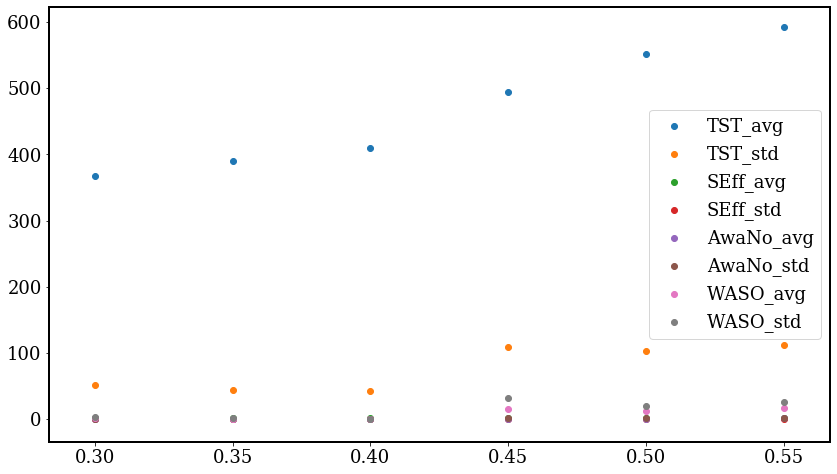

In [89]:
quant_pop = quant_pop.rename_axis('quantile')
population_avg = quant_pop.groupby('quantile').apply(np.mean)
population_avg = population_avg.rename_axis('quantile')

#plt.bar(x=population_avg.id, height=population_avg['TST_avg'])
for feat in features_id:
    plt.scatter(population_avg.index, population_avg[feat], label=feat)
plt.legend()
plt.show()